In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/27-class-sign-language-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/27-class-sign-language-dataset/Y.npy
/kaggle/input/27-class-sign-language-dataset/X.npy


In [2]:
# Load features (images) and labels
X = np.load('/kaggle/input/27-class-sign-language-dataset/X.npy')
y = np.load('/kaggle/input/27-class-sign-language-dataset/Y.npy')

In [3]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D,Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

2025-04-17 19:51:33.697428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744919493.929703     435 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744919494.002898     435 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def resize_images(images, target_size=(128,128)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

X_resized = resize_images(X)

In [5]:
images = X.astype('float32')
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y.reshape(-1))
y_categorical = to_categorical(labels)

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,  
    fill_mode='nearest'
)
X_train, X_val, y_train, y_val = train_test_split(
    X_resized, y_categorical, test_size=0.2, random_state=42
)

train_generator = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=32,
    shuffle=True
)

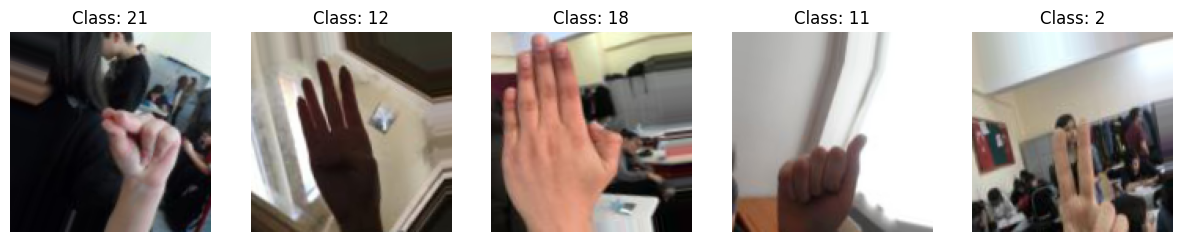

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(images, labels, num_samples=5, augmentation_type="Original"):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        
        # For grayscale images (single channel)
        if images[i].shape[-1] == 1:
            plt.imshow(images[i].squeeze(), cmap='gray')
        else:
            plt.imshow(images[i])
            
        plt.title(f"{augmentation_type}\nClass: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

# Generate a batch of augmented images
aug_images, aug_labels = next(train_generator)  # Correct syntax

# Plot samples
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    
    # For grayscale images (1 channel)
    if aug_images[i].shape[-1] == 1:
        plt.imshow(aug_images[i].squeeze(), cmap='gray')
    else:
        plt.imshow(aug_images[i])
    
    plt.title(f"Class: {np.argmax(aug_labels[i])}")
    plt.axis('off')
plt.show()

In [8]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers:
    if 'block8' in layer.name or 'conv_7b' in layer.name:
        layer.trainable = True


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(27, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


I0000 00:00:1744919511.466797     435 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744919511.467416     435 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10


I0000 00:00:1744919555.713861     475 service.cc:148] XLA service 0x77f78c103f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744919555.714696     475 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744919555.714718     475 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744919560.107615     475 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/570 ━━━━━━━━━━━━━━━━━━━━ 6:33:36 42s/step - accuracy: 0.0000e+00 - loss: 3.6400

I0000 00:00:1744919568.405592     475 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


570/570 ━━━━━━━━━━━━━━━━━━━━ 102s 107ms/step - accuracy: 0.1059 - loss: 3.2074 - val_accuracy: 0.3885 - val_loss: 2.0664
Epoch 2/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - accuracy: 0.3896 - loss: 2.0243 - val_accuracy: 0.5606 - val_loss: 1.3826
Epoch 3/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.5566 - loss: 1.4001 - val_accuracy: 0.6567 - val_loss: 1.0543
Epoch 4/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.6608 - loss: 1.0443 - val_accuracy: 0.7097 - val_loss: 0.8639
Epoch 5/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.7201 - loss: 0.8418 - val_accuracy: 0.7476 - val_loss: 0.7490
Epoch 6/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.7843 - loss: 0.6716 - val_accuracy: 0.7786 - val_loss: 0.6637
Epoch 7/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.8219 - loss: 0.5505 - val_accuracy: 0.7961 - val_loss: 0.6049
Epoch 8/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.8549 - loss: 0.4461 - val_accur

In [11]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8359 - loss: 0.5270
Validation Accuracy: 83.60%
Validation Loss: 0.5225


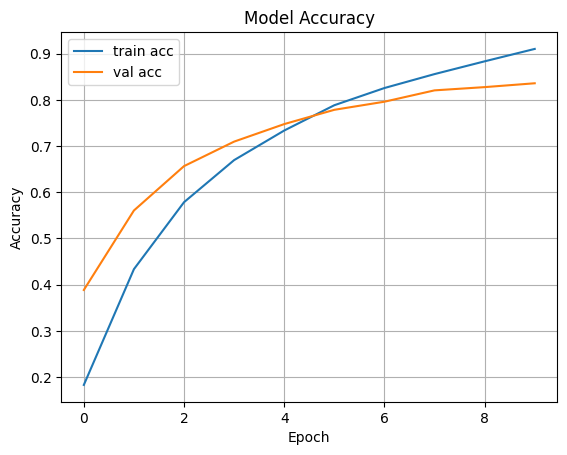

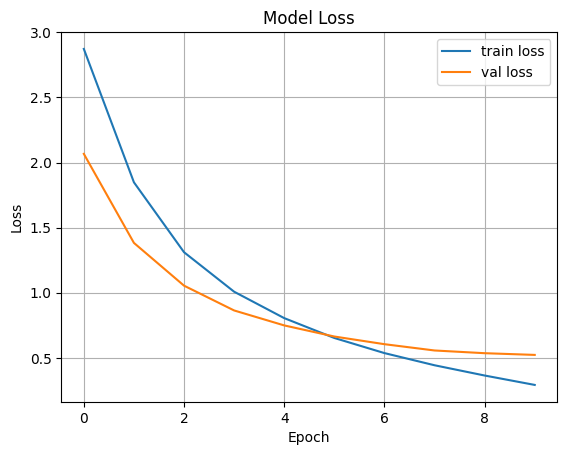

In [12]:
# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()